# Football Risk Analytics – EDA (Risk & Scouting)

## Objetivo
Analizar la relación entre **carga de minutos recientes** y la probabilidad de **riesgo elevado** en el siguiente partido (`high_risk_next`), usando un *proxy* basado en ACWR.

## Contenido
1. Setup + carga de datos desde DuckDB  
2. Descripción rápida del dataset  
3. Visualizaciones:
   - Distribución de minutos
   - Distribución ACWR (con zonas)
   - Riesgo vs carga 7d (buckets)
   - Riesgo vs carga 7d (deciles, curva)
4. Key findings (métricas calculadas automáticamente)


In [17]:
# --- Kernel / entorno (sanity check) ---
import sys
sys.executable

'c:\\Users\\manue\\OneDrive\\Desktop\\football-risk-analytics\\.venv\\Scripts\\python.exe'

In [18]:
# --- Working directory (para depurar rutas si hiciera falta) ---
import os
os.getcwd()

'c:\\Users\\manue\\OneDrive\\Desktop\\football-risk-analytics\\notebooks'

In [19]:
# === SETUP ===
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Estilo base (matplotlib puro)
plt.rcParams.update({
    "figure.figsize": (9, 4),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def resolve_db_path(filename: str = "analytics.duckdb") -> Path:
    """Resuelve la ruta al DuckDB de forma robusta desde notebooks/ o desde raíz."""
    cwd = Path.cwd()
    candidates = [
        cwd / "lakehouse" / filename,          # si ejecutas desde la raíz
        cwd.parent / "lakehouse" / filename,   # si ejecutas desde notebooks/
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(
        "No encuentro el DuckDB. He probado: "
        + " | ".join(str(p) for p in candidates)
        + "\nAsegúrate de que existe lakehouse/analytics.duckdb (o que el junction/symlink está creado)."
    )

DB_PATH = resolve_db_path()
DB_PATH

WindowsPath('c:/Users/manue/OneDrive/Desktop/football-risk-analytics/lakehouse/analytics.duckdb')

In [20]:
# === LOAD DATA ===
with duckdb.connect(str(DB_PATH)) as con:
    df = con.execute("SELECT * FROM player_dataset_final").df()
    dfp = con.execute("""
        SELECT *
        FROM player_dataset_predictive
        WHERE acwr IS NOT NULL
    """).df()

df.shape, dfp.shape

((97722, 22), (51569, 23))

## Descripción rápida
Aquí validamos rangos básicos y columnas clave que usaremos en EDA.


In [21]:
# Columnas esperadas (si alguna falta, lo veremos rápido)
expected = ["minutes", "minutes_last_7d", "acwr", "high_risk_next"]
missing = [c for c in expected if c not in dfp.columns]
missing

[]

In [22]:
# Describe de variables clave
dfp[[c for c in ["minutes", "minutes_last_7d", "acwr", "high_risk_next"] if c in dfp.columns]].describe(include="all")

,minutes,minutes_last_7d,acwr,high_risk_next
count,51569.000000,51569.000000,51569.000000,51569.000000
mean,84.227036,143.522291,1.890822,0.557409
std,20.169076,54.370076,0.837494,0.496698
min,0.000000,2.000000,0.028269,0.000000
25%,86.000000,93.000000,1.328520,0.000000
50%,93.000000,159.000000,1.847059,1.000000
75%,94.000000,187.000000,2.291022,1.000000
max,130.000000,323.000000,4.000000,1.000000


# Visualizaciones


## A) Distribución de minutos (recorte p99 + mediana)
Recortamos a p99 para que outliers no aplasten el histograma.


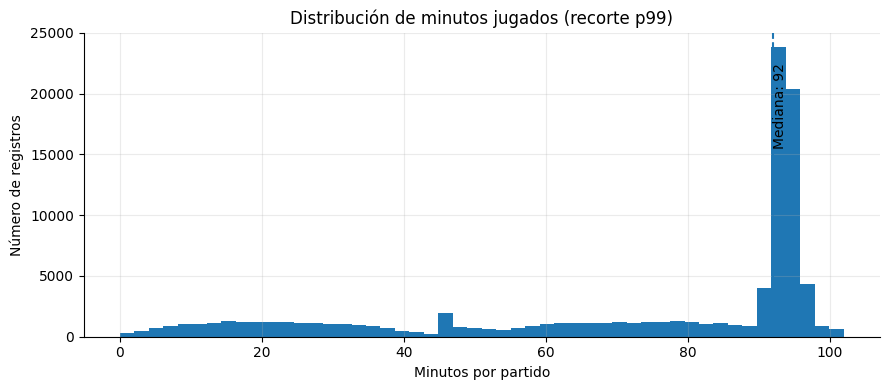

In [23]:
x = df["minutes"].dropna()
p99 = x.quantile(0.99)
x_clip = x[x <= p99]

fig, ax = plt.subplots()
ax.hist(x_clip, bins=50)

ax.set_title("Distribución de minutos jugados (recorte p99)")
ax.set_xlabel("Minutos por partido")
ax.set_ylabel("Número de registros")

median = x.median()
ax.axvline(median, linestyle="--")
ax.text(median, ax.get_ylim()[1]*0.9, f"Mediana: {median:.0f}", rotation=90, va="top")

plt.tight_layout()
plt.show()

## B) Distribución ACWR (recorte p01–p99 + zonas)
Zonas típicas para storytelling (no prescriptivo):
- **< 0.8**: underload
- **0.8 – 1.3**: sweet spot
- **> 1.3**: spike


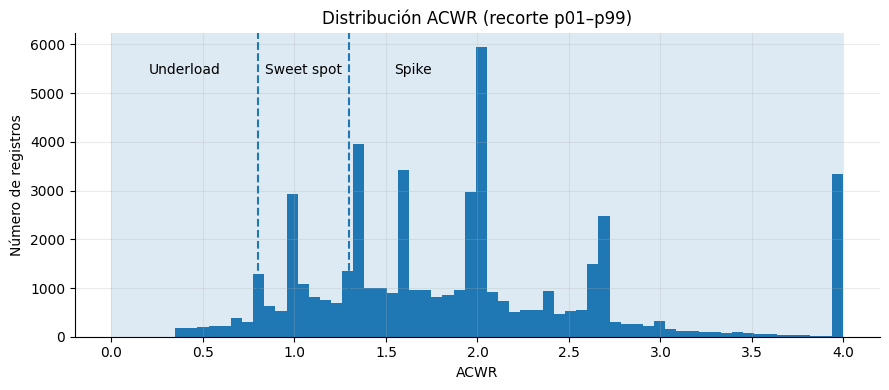

In [24]:
x = dfp["acwr"].dropna()

p01, p99 = x.quantile([0.01, 0.99])
x_clip = x[(x >= p01) & (x <= p99)]

fig, ax = plt.subplots()
ax.hist(x_clip, bins=60)

ax.set_title("Distribución ACWR (recorte p01–p99)")
ax.set_xlabel("ACWR")
ax.set_ylabel("Número de registros")

ax.axvspan(0.0, 0.8, alpha=0.15)
ax.axvspan(0.8, 1.3, alpha=0.15)
ax.axvspan(1.3, max(2.0, float(x_clip.max())), alpha=0.15)

ax.axvline(0.8, linestyle="--")
ax.axvline(1.3, linestyle="--")

ax.text(0.4, ax.get_ylim()[1]*0.9, "Underload", ha="center", va="top")
ax.text(1.05, ax.get_ylim()[1]*0.9, "Sweet spot", ha="center", va="top")
ax.text(1.65, ax.get_ylim()[1]*0.9, "Spike", ha="center", va="top")

plt.tight_layout()
plt.show()

## C) Riesgo vs carga 7d (buckets + % + N)
Gráfico “slide-ready” para presentar la relación carga→riesgo.


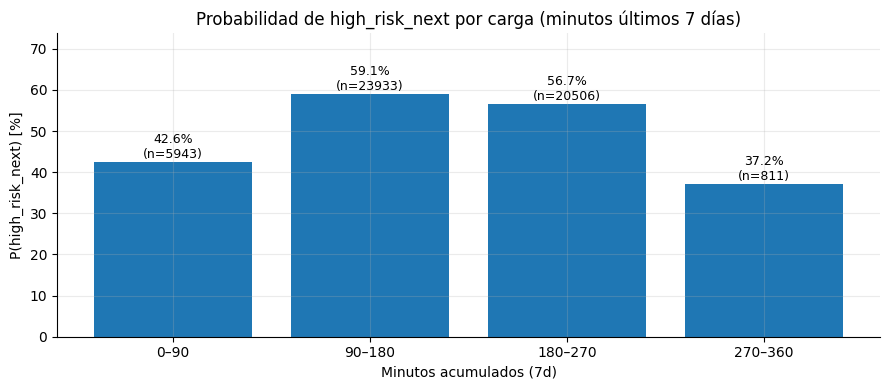

,bucket_7d,p_risk,n
0,0–90,0.425543,5943
1,90–180,0.591150,23933
2,180–270,0.566517,20506
3,270–360,0.372380,811


In [25]:
tmp = dfp.dropna(subset=["minutes_last_7d", "high_risk_next"]).copy()

# Recorte p99 para visualizar mejor
p99 = tmp["minutes_last_7d"].quantile(0.99)
tmp = tmp[tmp["minutes_last_7d"] <= p99]

bins = [0, 90, 180, 270, 360, 540, 1000]
labels = ["0–90", "90–180", "180–270", "270–360", "360–540", "540+"]

tmp["bucket_7d"] = pd.cut(
    tmp["minutes_last_7d"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

g = tmp.groupby("bucket_7d", observed=True).agg(
    p_risk=("high_risk_next", "mean"),
    n=("high_risk_next", "size")
).reset_index()

fig, ax = plt.subplots()
ax.bar(g["bucket_7d"].astype(str), g["p_risk"] * 100)

ax.set_title("Probabilidad de high_risk_next por carga (minutos últimos 7 días)")
ax.set_xlabel("Minutos acumulados (7d)")
ax.set_ylabel("P(high_risk_next) [%]")

ymax = float((g["p_risk"] * 100).max())
ax.set_ylim(0, max(5.0, ymax * 1.25))

for i, row in g.iterrows():
    ax.text(
        i,
        float(row["p_risk"] * 100) + 0.2,
        f"{row['p_risk']*100:.1f}%\n(n={int(row['n'])})",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

g

## D) Curva suave: riesgo vs carga 7d (deciles)
Binning por cuantiles para equilibrar tamaño por segmento.


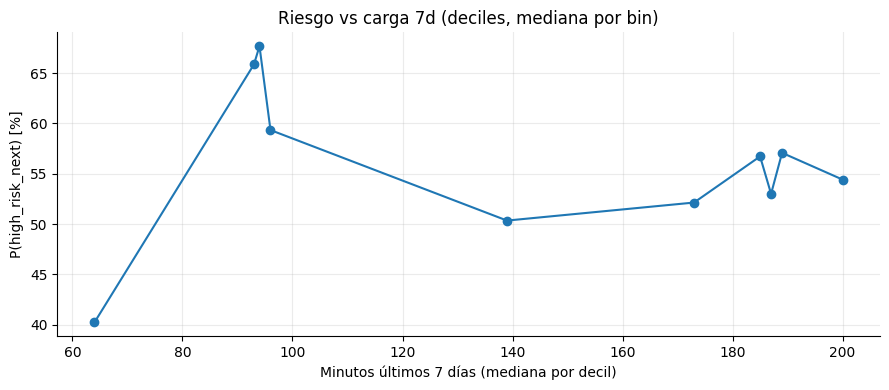

,qbin,x,p,n
0,"(1.999, 86.0]",64.0,0.402268,5203
1,"(86.0, 93.0]",93.0,0.658756,7795
2,"(93.0, 94.0]",94.0,0.676883,3491
3,"(94.0, 114.0]",96.0,0.593470,4012
4,"(114.0, 158.0]",139.0,0.503497,5148


In [26]:
tmp = dfp.dropna(subset=["minutes_last_7d", "high_risk_next"]).copy()
tmp = tmp[tmp["minutes_last_7d"] <= tmp["minutes_last_7d"].quantile(0.99)]

tmp["qbin"] = pd.qcut(tmp["minutes_last_7d"], q=10, duplicates="drop")
gq = tmp.groupby("qbin", observed=True).agg(
    x=("minutes_last_7d", "median"),
    p=("high_risk_next", "mean"),
    n=("high_risk_next", "size")
).reset_index()

fig, ax = plt.subplots()
ax.plot(gq["x"], gq["p"] * 100, marker="o")

ax.set_title("Riesgo vs carga 7d (deciles, mediana por bin)")
ax.set_xlabel("Minutos últimos 7 días (mediana por decil)")
ax.set_ylabel("P(high_risk_next) [%]")

plt.tight_layout()
plt.show()

gq.head()

# Key findings (auto)
Calculamos métricas para poder escribir conclusiones cuantitativas en README / presentación.


In [27]:
# Baseline risk
baseline = float(dfp["high_risk_next"].mean())

# Comparativa simple: por encima de umbral (ej: 360 min/7d) vs baseline
thr = 360
risk_hi = float(dfp.loc[dfp["minutes_last_7d"] >= thr, "high_risk_next"].mean())
risk_lo = float(dfp.loc[dfp["minutes_last_7d"] < thr, "high_risk_next"].mean())

# Lift relativo
lift_hi = (risk_hi / baseline - 1.0) if baseline > 0 else np.nan

summary = pd.DataFrame([{
    "baseline_risk": baseline,
    f"risk_minutes7d_ge_{thr}": risk_hi,
    f"risk_minutes7d_lt_{thr}": risk_lo,
    "relative_lift_ge_thr": lift_hi,
    "n_total": int(dfp.shape[0]),
    f"n_ge_{thr}": int((dfp["minutes_last_7d"] >= thr).sum()),
    f"n_lt_{thr}": int((dfp["minutes_last_7d"] < thr).sum()),
}])

summary

,baseline_risk,risk_minutes7d_ge_360,risk_minutes7d_lt_360,relative_lift_ge_thr,n_total,n_ge_360,n_lt_360
0,0.557409,NaN,0.557409,NaN,51569,0,51569


## Conclusión (para copiar al README)
- La **carga 7d** muestra asociación positiva con `high_risk_next` en este proxy.
- A partir de un umbral (ej. **360 min/7d**) se observa incremento relativo del riesgo (ver tabla arriba).
- Esto justifica pasar a un **modelo supervisado** (baseline logistic + modelos no lineales) y evaluar con CV.
